* [Atributos](#Atributos) 
* [Pré-processamento de dados](#Processamento-de-dados) 
    * [Dados numericos para categoricos](#Dados-numericos-para-categoricos) 
    * [Dados categoricos para dummies](#Dados-categoricos-para-dummies) 
* [Clusterização](#Clusters-com-o-KMeans) 
    * [Escolhendo o numero de clusters](#Escolhendo-o-numero-de-clusters) 
    * [Aplicando o K-Means com 4 clusters](#Aplicando-o-K-Means-com-4-clusters) 
* [Analise geral dos clusters](#Analise-geral-dos-clusters)

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Atributos
1. Age: idade do paciente [anos]
2. Sex: sexo do paciente [M: Masculino, F: Feminino]
3. ChestPainType: tipo de dor no peito [TA: Angina Típica, ATA: Angina Atípica, NAP: Dor Não Anginosa, ASY: Assintomática]
4. RestingBP: pressão arterial em repouso [mm Hg]
5. Cholesterol: colesterol sérico [mm/dl]
6. FastingBS: açúcar no sangue em jejum [1: se JejumBS > 120 mg/dl, 0: caso contrário]
7. RestingECG: resultados do eletrocardiograma em repouso [Normal: Normal, ST: com anormalidade da onda ST-T (inversões da onda T e/ou elevação ou depressão do ST > 0,05 mV), HVE: 8. mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes]
8. MaxHR: frequência cardíaca máxima alcançada [Valor numérico entre 60 e 202]
9. ExerciseAngina: angina induzida por exercício [S: Sim, N: Não]
10. Oldpeak: oldpeak = ST [Valor numérico medido na depressão]
11. ST_Slope: a inclinação do segmento ST do exercício de pico [Up: ascendente, Flat: plano, Down: descendente]
12. HeartDisease: classe de saída [1: doença cardíaca, 0: normal]

<div align="center">
    <img src=dataset-cover.jpg/>
<div>

In [84]:
df = pd.read_csv('heart.csv')

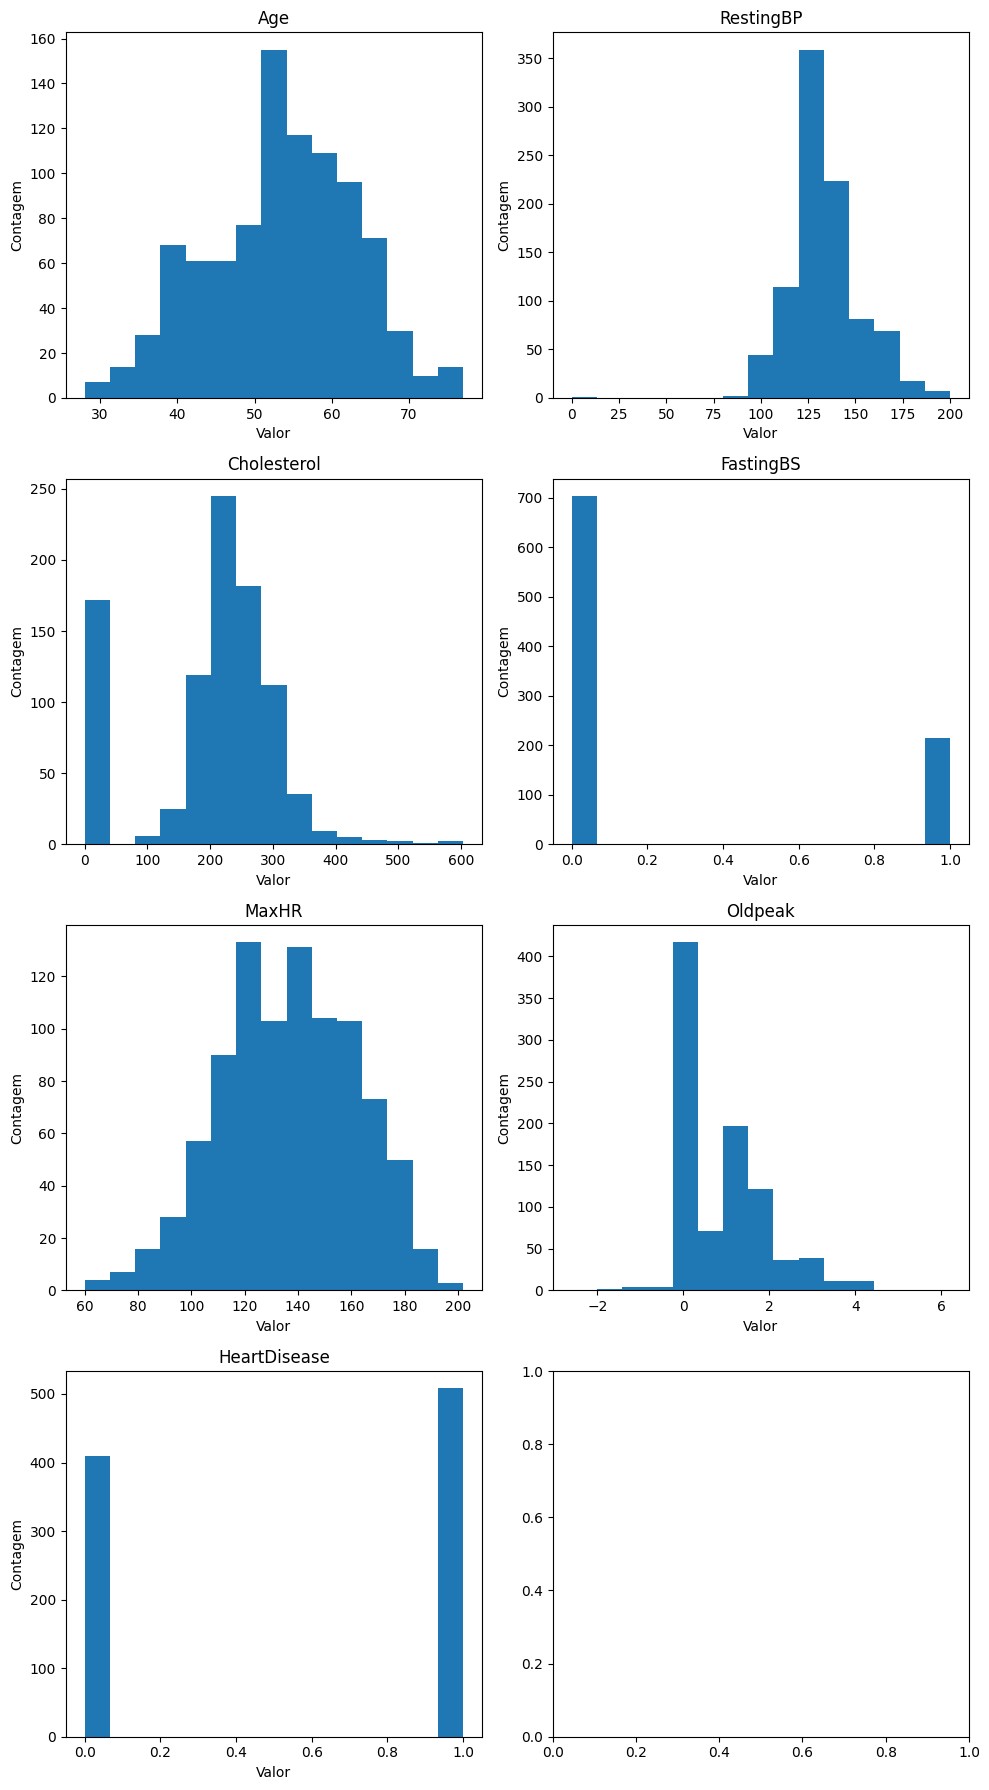

In [61]:
#Distribuição dos dados númericos
f,ax = plt.subplots(4,2,figsize=(10,18))
ax = ax.ravel()
for x in np.arange(df[['Age','RestingBP','Cholesterol','FastingBS','MaxHR','Oldpeak','HeartDisease']].shape[1]):
    ax[x].hist(df[df[['Age','RestingBP','Cholesterol','FastingBS','MaxHR','Oldpeak','HeartDisease']].columns[x]],bins=15)
    ax[x].set_title(df[['Age','RestingBP','Cholesterol','FastingBS','MaxHR','Oldpeak','HeartDisease']].columns[x])
    ax[x].set_xlabel('Valor')
    ax[x].set_ylabel('Contagem')
plt.tight_layout()

<Axes: >

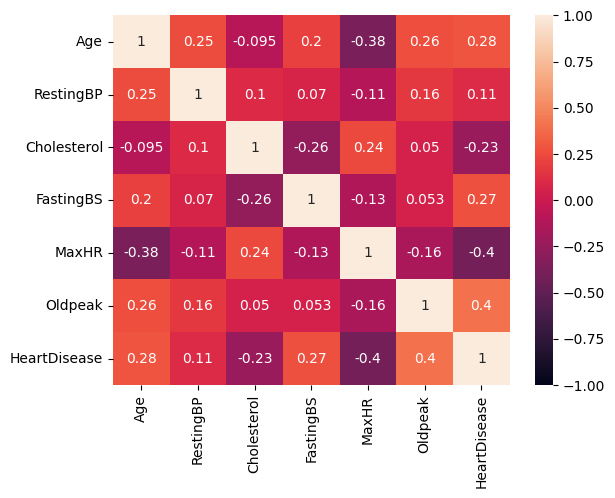

In [62]:
#Correlação entre os dados númericos
sns.heatmap(df[['Age','RestingBP','Cholesterol','FastingBS','MaxHR','Oldpeak','HeartDisease']].corr(),vmin=-1,vmax=1,annot=True)

## Processamento de dados

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [64]:
df.nunique()

Age                50
Sex                 2
ChestPainType       4
RestingBP          67
Cholesterol       222
FastingBS           2
RestingECG          3
MaxHR             119
ExerciseAngina      2
Oldpeak            53
ST_Slope            3
HeartDisease        2
dtype: int64

### Dados numericos para categoricos

In [65]:
def age_fase(age):
    age_fase = []
    for a in age:
        if a<45:
            age_fase.append('adult')
        elif a<60:
            age_fase.append('midle-age')
        else:
            age_fase.append('old')
    return pd.Series(age_fase)

In [66]:
def BP_level(BP):
    PBP_level = []
    for bp in BP:
        if bp<120:
            PBP_level.append('normal')
        elif bp<130:
            PBP_level.append('elevated')
        elif bp<140:
            PBP_level.append('hypert_s1')   #Hypertension stage 1
        elif bp<180:
            PBP_level.append('hypert_s2')
        else:
            PBP_level.append('hypert_crisis')   #Hypertension crise
    return pd.Series(PBP_level)

In [67]:
def Cholesterol_level(cholesterol):
    clt_level = []
    for c in cholesterol:
        if c<200:
            clt_level.append('healthy')
        elif c<240:
            clt_level.append('borderline')
        else:
            clt_level.append('dangerous')
    return pd.Series(clt_level)

In [68]:
def FastingBS_level(bs):
    FastBS = []
    for b in bs:
        if b==1:
            FastBS.append('diabetic')
        else:
            FastBS.append('normal')
    return pd.Series(FastBS)

In [69]:
def level_heart_rate(age,max_heart):
    level_heart = []
    for a,h in zip(age,max_heart):
        max_rate = (220-a)*0.8        #Frequencia maxima saudável do coração em exercicios fisicos
        min_rate = (220-a)*0.5        #Frequencia minima saudável do coração em exercicios fisicos
        if h<min_rate:
            level_heart.append('low')
        elif h<=max_rate:
            level_heart.append('ideal')
        else:
            level_heart.append('high')
    return pd.Series(level_heart)

In [70]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [71]:
df['MaxHR'] = level_heart_rate(df['Age'],df['MaxHR'])
df['Age'] = age_fase(df['Age'])
df['RestingBP'] = BP_level(df['RestingBP'])
df['Cholesterol'] = Cholesterol_level(df['Cholesterol'])
df['FastingBS'] = FastingBS_level(df['FastingBS'])

In [72]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,adult,M,ATA,hypert_s2,dangerous,normal,Normal,high,N,0.0,Up,0
1,midle-age,F,NAP,hypert_s2,healthy,normal,Normal,high,N,1.0,Flat,1
2,adult,M,ATA,hypert_s1,dangerous,normal,ST,ideal,N,0.0,Up,0
3,midle-age,F,ASY,hypert_s1,borderline,normal,Normal,ideal,Y,1.5,Flat,1
4,midle-age,M,NAP,hypert_s2,healthy,normal,Normal,ideal,N,0.0,Up,0


### Dados categoricos para dummies
Este processo possibilita a ultilização de dados categoricos para criação de modelos de ML

In [73]:
df_d = pd.get_dummies(df)
df_d.head()

,Oldpeak,HeartDisease,Age_adult,Age_midle-age,Age_old,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,...,RestingECG_Normal,RestingECG_ST,MaxHR_high,MaxHR_ideal,MaxHR_low,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,0.0,0,True,False,False,False,True,False,True,False,...,True,False,True,False,False,True,False,False,False,True
1,1.0,1,False,True,False,True,False,False,False,True,...,True,False,True,False,False,True,False,False,True,False
2,0.0,0,True,False,False,False,True,False,True,False,...,False,True,False,True,False,True,False,False,False,True
3,1.5,1,False,True,False,True,False,True,False,False,...,True,False,False,True,False,False,True,False,True,False
4,0.0,0,False,True,False,False,True,False,False,True,...,True,False,False,True,False,True,False,False,False,True


In [74]:
x = df_d.div(df_d.sum(axis=1),axis='rows')
x.head()

,Oldpeak,HeartDisease,Age_adult,Age_midle-age,Age_old,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,...,RestingECG_Normal,RestingECG_ST,MaxHR_high,MaxHR_ideal,MaxHR_low,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,0.0,0.0,0.1,0.0,0.0,0.0,0.1,0.0,0.1,0.0,...,0.1,0.0,0.1,0.0,0.0,0.1,0.0,0.0,0.0,0.1
1,0.083333,0.083333,0.0,0.083333,0.0,0.083333,0.0,0.0,0.0,0.083333,...,0.083333,0.0,0.083333,0.0,0.0,0.083333,0.0,0.0,0.083333,0.0
2,0.0,0.0,0.1,0.0,0.0,0.0,0.1,0.0,0.1,0.0,...,0.0,0.1,0.0,0.1,0.0,0.1,0.0,0.0,0.0,0.1
3,0.12,0.08,0.0,0.08,0.0,0.08,0.0,0.08,0.0,0.0,...,0.08,0.0,0.0,0.08,0.0,0.0,0.08,0.0,0.08,0.0
4,0.0,0.0,0.0,0.1,0.0,0.0,0.1,0.0,0.0,0.1,...,0.1,0.0,0.0,0.1,0.0,0.1,0.0,0.0,0.0,0.1


## Clusters com o KMeans

In [75]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### Escolhendo o numero de clusters

In [76]:
distortion = []
score = []
n_clusters = range(2,15)

for n_clus in n_clusters:
    kmeans = KMeans(n_clusters=n_clus,max_iter=10_000,n_init=100,random_state=61658).fit(x)
    distortion.append( kmeans.inertia_ )
    score.append( silhouette_score(x, kmeans.labels_) )

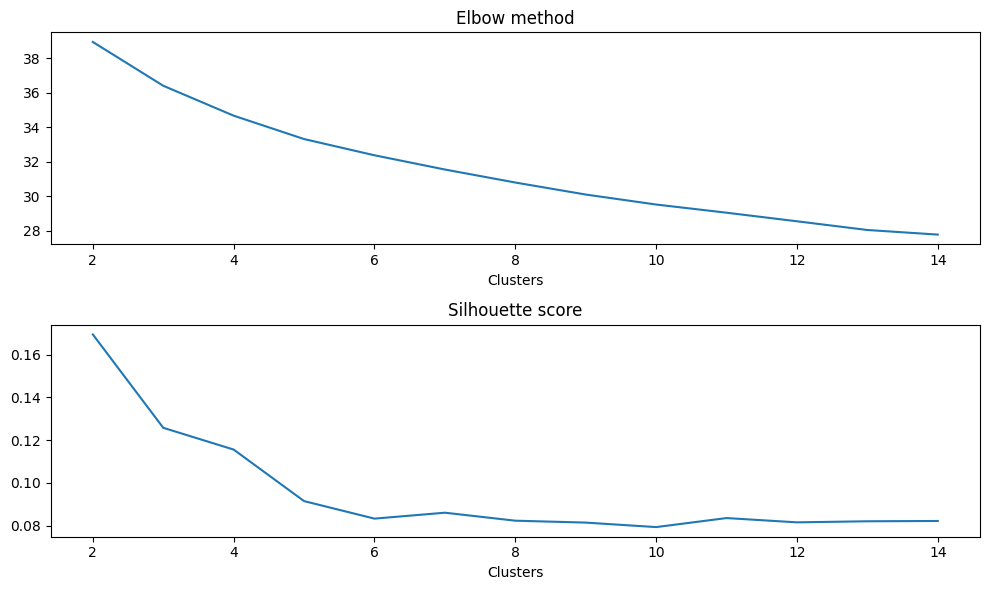

In [77]:
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(10,6))
ax[0].plot(n_clusters,distortion)
ax[0].set_xlabel('Clusters')
ax[0].set_title('Elbow method')
ax[1].plot(n_clusters,score)
ax[1].set_xlabel('Clusters')
ax[1].set_title('Silhouette score')
plt.tight_layout()

### Aplicando o K-Means com 4 clusters

In [78]:
km = KMeans(n_clusters=4,max_iter=10_000,n_init=100,random_state=61658)
x_t = km.fit_predict(x)

In [79]:
df['Cluster'] = x_t
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Cluster
0,adult,M,ATA,hypert_s2,dangerous,normal,Normal,high,N,0.0,Up,0,1
1,midle-age,F,NAP,hypert_s2,healthy,normal,Normal,high,N,1.0,Flat,1,0
2,adult,M,ATA,hypert_s1,dangerous,normal,ST,ideal,N,0.0,Up,0,1
3,midle-age,F,ASY,hypert_s1,borderline,normal,Normal,ideal,Y,1.5,Flat,1,3
4,midle-age,M,NAP,hypert_s2,healthy,normal,Normal,ideal,N,0.0,Up,0,1


In [80]:
for col in df.drop('Cluster', axis=1).columns:
    for cl in np.sort(df['Cluster'].unique()):
        if df.dtypes[col] == object:
            vc = 100*df.loc[df['Cluster']==cl,col].value_counts() / (df['Cluster']==cl).sum()
            for cat,cnt in vc.reset_index().values:
                print(f'{cl:d};{col}_{str(cat):s};{cnt:5.2f}%'.replace('.',','))
        else:
            print(f'{cl:d};{col};{df.loc[df.Cluster==cl,col].mean():.2f}'.replace('.',','))

for col in df.drop('Cluster',axis=1).columns:
    if df.dtypes[col] == object:
        vc = 100*df[col].value_counts() / (df.shape[0])
        for cat,cnt in vc.reset_index().values:
            print(f'All;{col}_{str(cat):s};{cnt:5.2f}%'.replace('.',','))
    else:
        print(f'All;{col};{df.loc[:,col].mean():.2f}'.replace('.',','))

0;Age_midle-age;54,23%
0;Age_adult;26,06%
0;Age_old;19,72%
1;Age_midle-age;55,88%
1;Age_adult;34,03%
1;Age_old;10,08%
2;Age_midle-age;51,81%
2;Age_old;32,64%
2;Age_adult;15,54%
3;Age_midle-age;51,30%
3;Age_old;40,00%
3;Age_adult; 8,70%
0;Sex_F;100,00%
1;Sex_M;100,00%
2;Sex_M;94,82%
2;Sex_F; 5,18%
3;Sex_M;88,12%
3;Sex_F;11,88%
0;ChestPainType_ATA;40,85%
0;ChestPainType_NAP;35,21%
0;ChestPainType_ASY;18,31%
0;ChestPainType_TA; 5,63%
1;ChestPainType_ATA;39,92%
1;ChestPainType_NAP;29,83%
1;ChestPainType_ASY;26,05%
1;ChestPainType_TA; 4,20%
2;ChestPainType_ASY;76,17%
2;ChestPainType_NAP;14,51%
2;ChestPainType_TA; 5,70%
2;ChestPainType_ATA; 3,63%
3;ChestPainType_ASY;75,65%
3;ChestPainType_NAP;15,65%
3;ChestPainType_TA; 4,93%
3;ChestPainType_ATA; 3,77%
0;RestingBP_hypert_s1;28,17%
0;RestingBP_elevated;26,06%
0;RestingBP_hypert_s2;23,24%
0;RestingBP_normal;21,13%
0;RestingBP_hypert_crisis; 1,41%
1;RestingBP_hypert_s2;29,83%
1;RestingBP_elevated;26,47%
1;RestingBP_hypert_s1;25,21%
1;RestingBP_n

## Analise geral dos clusters
Analise feita com o excel, para ter mais detalhes entrar no arquivo do diretório: Analise_clusters.xlsx

In [81]:
analisys = pd.read_excel('Analise_clusters.xlsx','Avaliação_geral')
analisys.head()

,Interpretação,Idade,Tipo de dor no peito,Colesterol,Agina por exercícios,Açucar no sangue,Doença cardiaca,Batimento maximo,depressão ST,Pressão arterial,Eletrocardiograma,Sexo,Inclinação ST,Risco avaliação pessoal
0,0,Variado,"ATA, NAP e TA",Perigoso,Não,Normal,Não possui,Alto,Neutra,Variado,LVH,Feminino,Ascendente,Intermediario
1,1,Adultos e Meia idade,ATA e NAP,Limite,Não,Normal,Não possui,Alto,Baixa,Hipertensos,Normal,Masculino,Ascendente,Baixo
2,2,Adultos e idosos,ASY e TA,Normal,Variada,Diabeticos,Possui,Ideal e baixo,Baixa,Normal/elevado,ST,Masculino,Plana,Intermediario
3,3,Idosos,ASY,Perigoso,Sim,Normal,Possui,Ideal,Alto,Hipertensos,LVH/ST,Masculino,Plana/Descendente,Alto


<p>O risco foi determinado segundo o modelo do <a href="https://youtu.be/pd1Wz-Rclr8">vídeo</a></p>

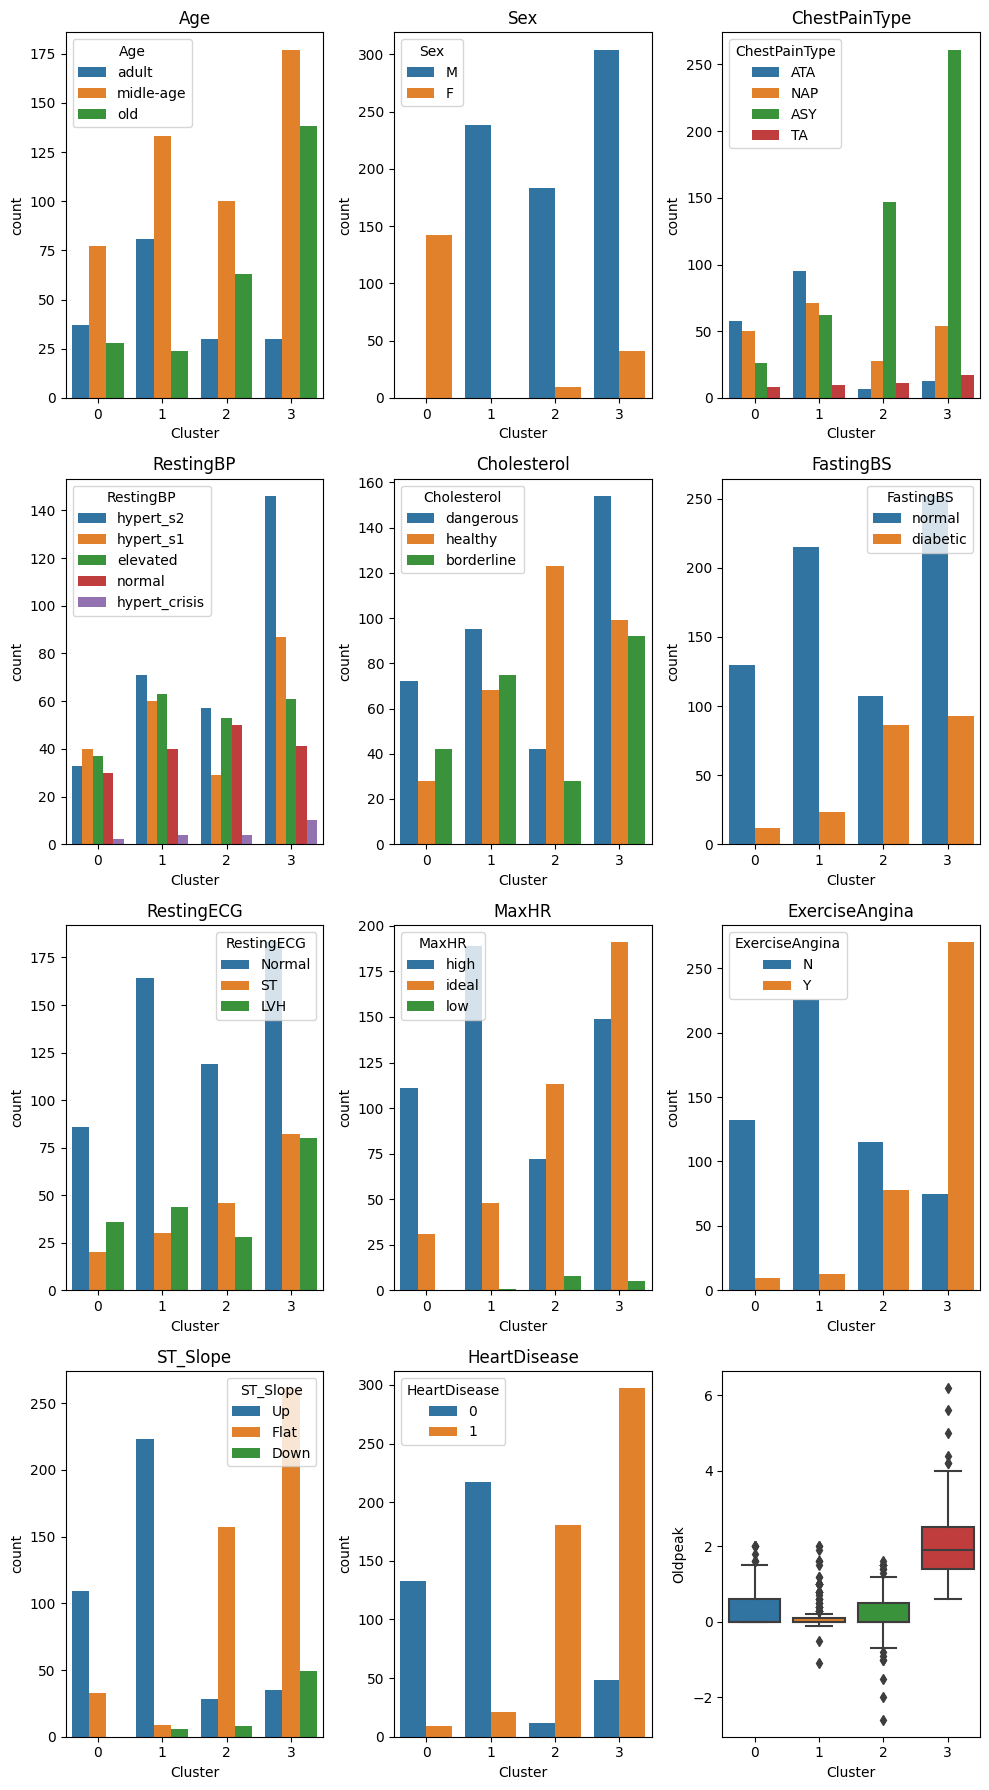

In [82]:
#Distribuição de cada atributo nos clusters
columns = pd.Series(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'ST_Slope', 'HeartDisease'])
fig, ax = plt.subplots(nrows=4,ncols=3,figsize=(10,18))
ax = ax.ravel()

for i in np.arange(columns.nunique()):
    sns.countplot(data=df, x='Cluster', hue=columns[i],ax=ax[i])
    ax[i].set_title(columns[i])
sns.boxplot(data=df, x='Cluster', y='Oldpeak')
plt.tight_layout()

Text(0, 0.5, 'Porcentagem de doença cardiaca')

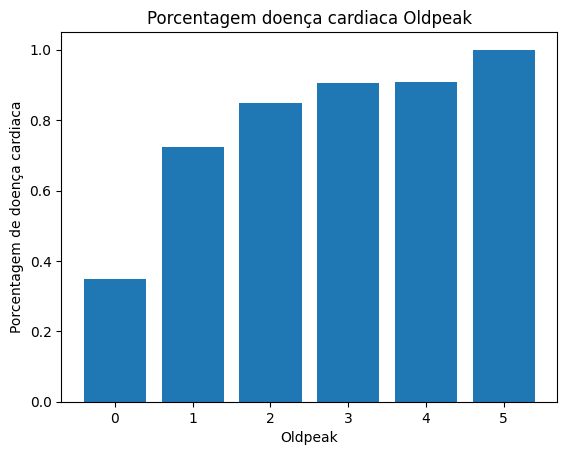

In [83]:
#Porcentagem de doença cardiaca em cada faixa do Oldpeak
pct_dc = []

for i in range(int(df['Oldpeak'].max())):
    pct_dc.append(
    int(sum(df[(df['Oldpeak']>=i)&(df['Oldpeak']<(i+1))]['HeartDisease']))/
    (df[(df['Oldpeak']>=i)&(df['Oldpeak']<(i+1))].shape[0]))

plt.bar(x=range(int(df['Oldpeak'].max())),height=pct_dc)
plt.title('Porcentagem doença cardiaca Oldpeak')
plt.xlabel('Oldpeak')
plt.ylabel('Porcentagem de doença cardiaca')